In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from core import networks

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## Define evolution

$$q_t = \mathcal{N}(x|0,\sigma_t)$$

In [4]:
device = torch.device('cuda')
space_dim = 1
sigma_0 = torch.tensor(5.0).to(device)
sigma_1 = torch.tensor(1.0).to(device)

mu_t = lambda t: torch.zeros([1,space_dim]).to(device)
sigma_t = lambda t: (1-t)*sigma_0 + t*sigma_1
q_t = lambda t, n: mu_t(t) + sigma_t(t)*torch.empty([n, space_dim]).to(device).normal_()

## Learning the potential

$$\int dx\;dt\;q_t\bigg[\frac{1}{2}\Vert\nabla s\Vert^2 + \frac{\partial s}{\partial t}\bigg] - \int dx\;\bigg[ q_1s_1 - q_0s_0\bigg] \to \min_s$$

In [5]:
torch.manual_seed(0)

net = networks.SmallMLP(2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(.9, .999))

n_iter = 5000
n_samples = 500
losses = np.zeros(n_iter)
for i in range(n_iter):
    for p in net.parameters(): p.grad = None
    
    t = torch.empty([n_samples,1]).uniform_().to(device)
    x = q_t(t,n_samples)
    
    x.requires_grad = True
    nabla_s = torch.autograd.grad(net(x, t).sum(), x, create_graph=True)[0]
    x = x.detach()
    
    t.requires_grad = True
    dsdt = torch.autograd.grad(net(x, t).sum(), t, create_graph=True)[0]
    t = t.detach()
    
    t_0 = torch.zeros([n_samples,1]).to(device)
    t_1 = torch.ones([n_samples,1]).to(device)
    loss = 0.5*(nabla_s**2).sum(1) + dsdt - net(q_t(t_1,n_samples),t_1) + net(q_t(t_0,n_samples),t_0)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    losses[i] = loss.detach().cpu().numpy()
    if (i % 100) == 0:
        print('iteration: %d, loss: %.3e' % (i,losses[i]))

iteration: 0, loss: 1.460e-01
iteration: 100, loss: -6.167e+00
iteration: 200, loss: -6.695e+00
iteration: 300, loss: -6.210e+00
iteration: 400, loss: -6.262e+00
iteration: 500, loss: -8.234e+00
iteration: 600, loss: -8.214e+00
iteration: 700, loss: -7.869e+00
iteration: 800, loss: -7.349e+00
iteration: 900, loss: -7.563e+00
iteration: 1000, loss: -6.488e+00
iteration: 1100, loss: -6.203e+00
iteration: 1200, loss: -7.222e+00
iteration: 1300, loss: -6.549e+00
iteration: 1400, loss: -6.147e+00
iteration: 1500, loss: -6.647e+00
iteration: 1600, loss: -7.816e+00
iteration: 1700, loss: -6.960e+00
iteration: 1800, loss: -8.121e+00
iteration: 1900, loss: -8.112e+00
iteration: 2000, loss: -8.339e+00
iteration: 2100, loss: -7.297e+00
iteration: 2200, loss: -7.731e+00
iteration: 2300, loss: -7.770e+00
iteration: 2400, loss: -7.036e+00
iteration: 2500, loss: -8.828e+00
iteration: 2600, loss: -7.010e+00
iteration: 2700, loss: -7.474e+00
iteration: 2800, loss: -7.552e+00
iteration: 2900, loss: -7.6

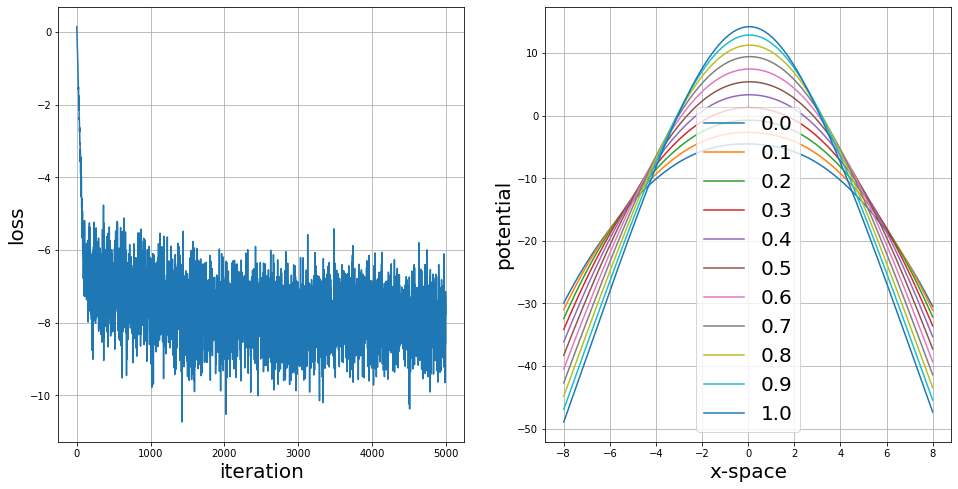

In [6]:
fs = 20

figsize(16,8)
plt.subplot(121)
plt.plot(losses)
plt.xlabel('iteration', fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.grid()
plt.subplot(122)
n_points = 200
for i in range(11):
    x = torch.linspace(-8,8,n_points).to(device)
    t = i/10*torch.ones(n_points).to(device)
    plt.plot(x.cpu().numpy(), net(x,t).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()

## Generation

In [8]:
n_samples = 2000
n_steps = 200
dt = 1./n_steps
t = torch.zeros([n_samples,1]).to(device)
x_t = q_t(t,n_samples)

t_1 = torch.ones([n_samples,1]).to(device)
x_1 = q_t(t_1,n_samples)

figsize(16,8)
for i in range(n_steps):
    x_t.requires_grad = True
    nabla_s = torch.autograd.grad(net(x_t, t).sum(), x_t)[0].detach()
    x_t = x_t.detach()
    x_t.data += dt*nabla_s
    t += dt
    
    if (i % 2) == 0:
        plt.subplot(121)
        plt.hist(x_t.cpu().numpy().flatten(), bins=40, alpha=0.4, 
                 density=True, label=r'$q_{%.3f}$' % t[0].cpu().numpy())
        plt.hist(x_1.cpu().numpy().flatten(), bins=40, alpha=0.4, 
                 density=True, label='target')
        plt.xlim(-8,8)
        plt.ylim(0.0,0.45)
        plt.legend(fontsize=fs, loc='upper right')
        plt.grid()
        
        plt.subplot(122)
        x_plot = torch.linspace(-8,8,n_points).to(device)
        t_plot = t[0]*torch.ones([n_points]).to(device)
        plt.plot(x_plot.cpu().numpy(), net(x_plot,t_plot).detach().cpu().numpy(), 
                 label='%.3f' % t[0].cpu().numpy())
        plt.plot()
        plt.ylim(-30,15)
        plt.xlim(-8,8)
        plt.legend(fontsize=fs, loc='upper right')
        plt.grid()
        plt.savefig('gifs/diffusion/%.3d.png' % i, bbox_inches='tight')
        plt.clf()

<Figure size 1152x576 with 0 Axes>

In [9]:
!convert -delay 10 -loop 0 ./gifs/diffusion/*.png ./gifs/diffusion.gif